In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download soumiknafiul/plantvillage-dataset-labeled

Dataset URL: https://www.kaggle.com/datasets/soumiknafiul/plantvillage-dataset-labeled
License(s): CC0-1.0
 93% 813M/874M [00:07<00:00, 83.4MB/s]
100% 874M/874M [00:07<00:00, 126MB/s] 


In [3]:
!unzip -q plantvillage-dataset-labeled.zip

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# --- Prepare Image Dataset ---
print("--- Preparing Image Dataset ---")
# Define image constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = 'PlantVillage Dataset (Labeled)/Color Images'

# 1. Load data from the directory you downloaded
print(f"Loading images from: {DATASET_PATH}")
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(f"Found {len(class_names)} classes.")

--- Preparing Image Dataset ---
Loading images from: PlantVillage Dataset (Labeled)/Color Images
Found 15915 files belonging to 19 classes.
Found 19 classes.


In [6]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# --- Build and Train CNN Model ---
print("\n--- Building CNN Model ---")


--- Building CNN Model ---


In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

In [17]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [18]:
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

In [19]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

In [20]:
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

# --- FIX IS HERE ---
# The number of units must match the number of classes found in the dataset.
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
# --------------------

model = Model(inputs, outputs)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │        24,339 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,282,323 (8.71 MB)

 Trainable params: 24,339 (95.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
# --- Define Callbacks ---
# Stop training when validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)


# --- Train the model ---
print("\n--- Starting Initial Training (Feature Extraction) ---")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50, # Set a high number; EarlyStopping will find the best epoch
    callbacks=[early_stopping, reduce_lr]
)


--- Starting Initial Training (Feature Extraction) ---
Epoch 1/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6620 - loss: 1.1781 - val_accuracy: 0.9196 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.9070 - loss: 0.2938 - val_accuracy: 0.9267 - val_loss: 0.2275 - learning_rate: 0.0010
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - accuracy: 0.9272 - loss: 0.2298 - val_accuracy: 0.9420 - val_loss: 0.1821 - learning_rate: 0.0010
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.9351 - loss: 0.1940 - val_accuracy: 0.9318 - val_loss: 0.2056 - learning_rate: 0.0010
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9402 - loss: 0.1822 - val_accuracy: 0.9401 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch 6/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.9419 - loss: 0.1660 - val_accuracy: 0.9407 - val_loss: 0.1754 - learning_rate: 0.0010
Epoch 7/50
398/398 ━

In [23]:
print("\n--- Evaluating on test data ---")
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy*100:.2f}%")


--- Evaluating on test data ---
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9541 - loss: 0.1251
Test Accuracy: 95.47%


In [24]:
# After the model.fit() call for your LFW model is complete
print("--- Saving the trained face recognition model ---")
model.save('disease_classifier_1.h5')
print("Model saved successfully!")

--- Saving the trained face recognition model ---
Model saved successfully!



--- Running Final Predictions on Validation Images ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


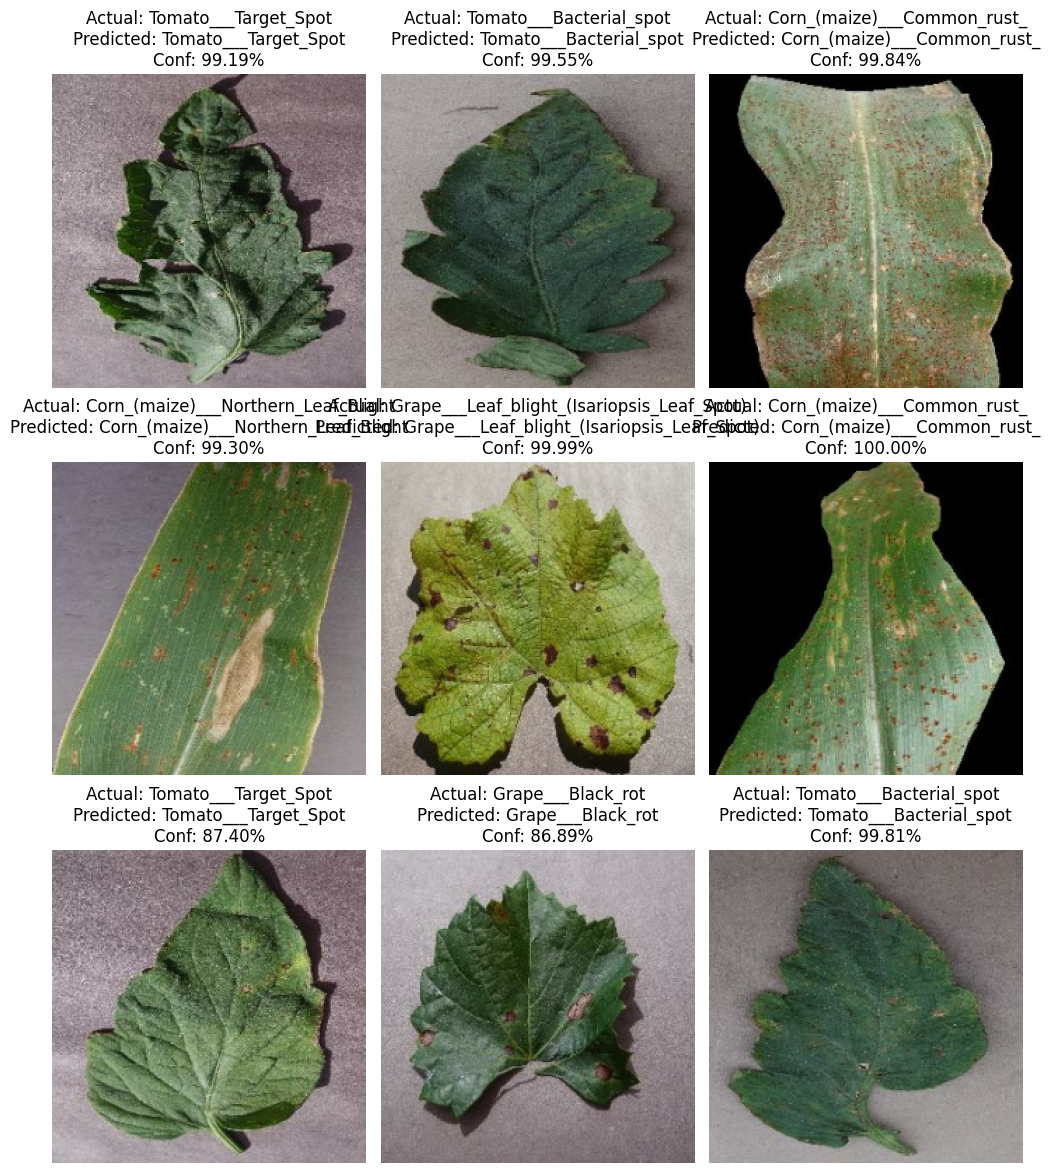

In [26]:
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Running Final Predictions on Validation Images ---")
plt.figure(figsize=(10, 12))
for images, labels in val_dataset.take(1): # Changed validation_dataset to val_dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        img_array = tf.expand_dims(images[i], 0)
        # Use the final_model for predictions
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        confidence = 100 * np.max(predictions[0])

        actual_name = class_names[labels[i]]
        predicted_name = class_names[predicted_class_index]

        plt.title(f"Actual: {actual_name}\nPredicted: {predicted_name}\nConf: {confidence:.2f}%")
        plt.axis("off")
plt.tight_layout()
plt.show()